In [34]:
%matplotlib inline 
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from sa_decomp_layer import SADecompLayer

import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K


from tensorflow.keras.layers import Layer
from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.compat.v1 import extract_image_patches
import numpy as np

from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential, load_model


In [35]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    if 'conv' not in layer.name:
        return None
    # get filter weights
    filters, biases = layer.get_weights()
    return (filters)
    #print(layer.name, filters.shape)

In [37]:
get_filter(1).shape

(3, 3, 3, 64)

## Block 1 

[[-0.0865837   0.19084392  0.16842183]
 [-0.18646947  0.17608799  0.15426615]
 [-0.23963833 -0.14159909 -0.10266907]]


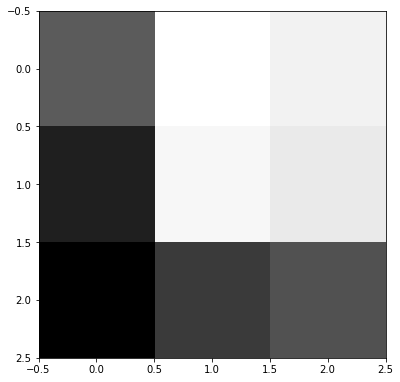

In [38]:
from skimage.feature import hog
from skimage import data, exposure

fig = plt.figure(figsize=(60, 60))

columns =8
rows = 8


filters = get_filter(1)
for i in range(4,filters.shape[-1]):
    filter = filters[:,:,:, i]
    #for j in range(filter.shape[-1]):
    f = filter[:,:, 0]
    _, hog_image = hog(f, orientations=8, pixels_per_cell=(3,3),
                    cells_per_block=(1, 1), visualize=True, channel_axis=None)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 100))
    fig.add_subplot(rows,columns, i+1)
    plt.imshow(f, cmap=plt.get_cmap('gray'))
    print(f)
    fff = f
    break

    #fig.add_subplot(rows,columns, i+2)
    #plt.imshow(hog_image_rescaled, cmap=plt.get_cmap('gray'))



plt.show()

In [39]:
hog_image

array([[0.        , 0.        , 0.        ],
       [0.        , 0.14357395, 0.        ],
       [0.        , 0.        , 0.        ]], dtype=float32)

In [40]:
from sklearn.decomposition import PCA
def get_filter_dominant_angle(filter):

    cov = np.cov(filter)
    pca = PCA(n_components=2)
    pca.fit(cov)
    pca.transform(cov)
    return np.cov(pca.components_)
    

In [41]:
filter = np.array([[-1, 1,1],
                   [-1, 0,1],
                   [-1, -1,-1]])


v = get_filter_dominant_angle(filter)
print(v)

print(np.linalg.eig(v))
_, ev = np.linalg.eig(v)
print(np.rad2deg(np.arctan2(-0.33333333, 0.16666667)))



[[ 0.33333333 -0.16666667]
 [-0.16666667  0.33333333]]
(array([0.16666667, 0.5       ]), array([[-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]]))
-63.43494813537266


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


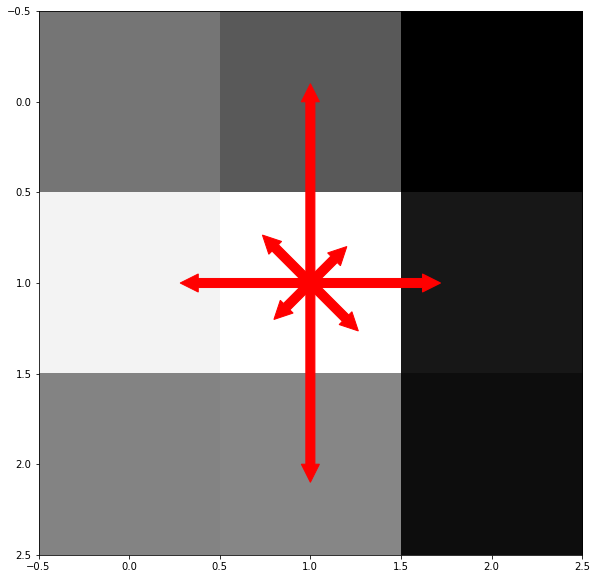

In [242]:
from turtle import width
from numpy import pad

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#f = np.array([[-1,1,1],[-1,0,1], [-1,-1,-1]])

def plotFilterDominantAngles(filters):
    for f in filters:
        #f = np.pad(f, pad_width = 200, mode="constant", constant_values=(0))
        dft  = np.fft.fft2(f)
        dft_shift = np.fft.fftshift(dft)
        dft_shift = np.rot90(dft_shift) 
        dft_shift = np.around(dft_shift, decimals=4)

        phase= np.angle(dft_shift)
        mag = np.abs(dft_shift)

        #print(phase)
        plt.imshow(mag, cmap='gray')

        mag = mag - mag[1,1]
        #print(mag)

        mag_n = NormalizeData(mag)

        plt.imshow(f, cmap='gray')
        for i in range(-1,2):
            for j in range(-1, 2):
                if mag[i+1,j+1] > 0 :
                    theta = np.arctan2(i,j)
                    plt.arrow(1, 1, mag_n[i+1,j+1]*np.cos(theta), mag_n[i+1,j+1]*np.sin(theta), head_width=0.1, head_length=0.1, fc='red', ec='red', width=0.05)




plotFilterDominantAngles([f])

In [80]:
mag = np.array([[0.15011312, 1.235253   ,0.43233627],
 [1.20760753, 0.    ,     1.20760753],
 [0.43233627 ,1.235253,   0.15011312]])
np.min(np.ma.array(mag, mask=mag<=0))

0.15011312

# Dominant orientations for Block 1

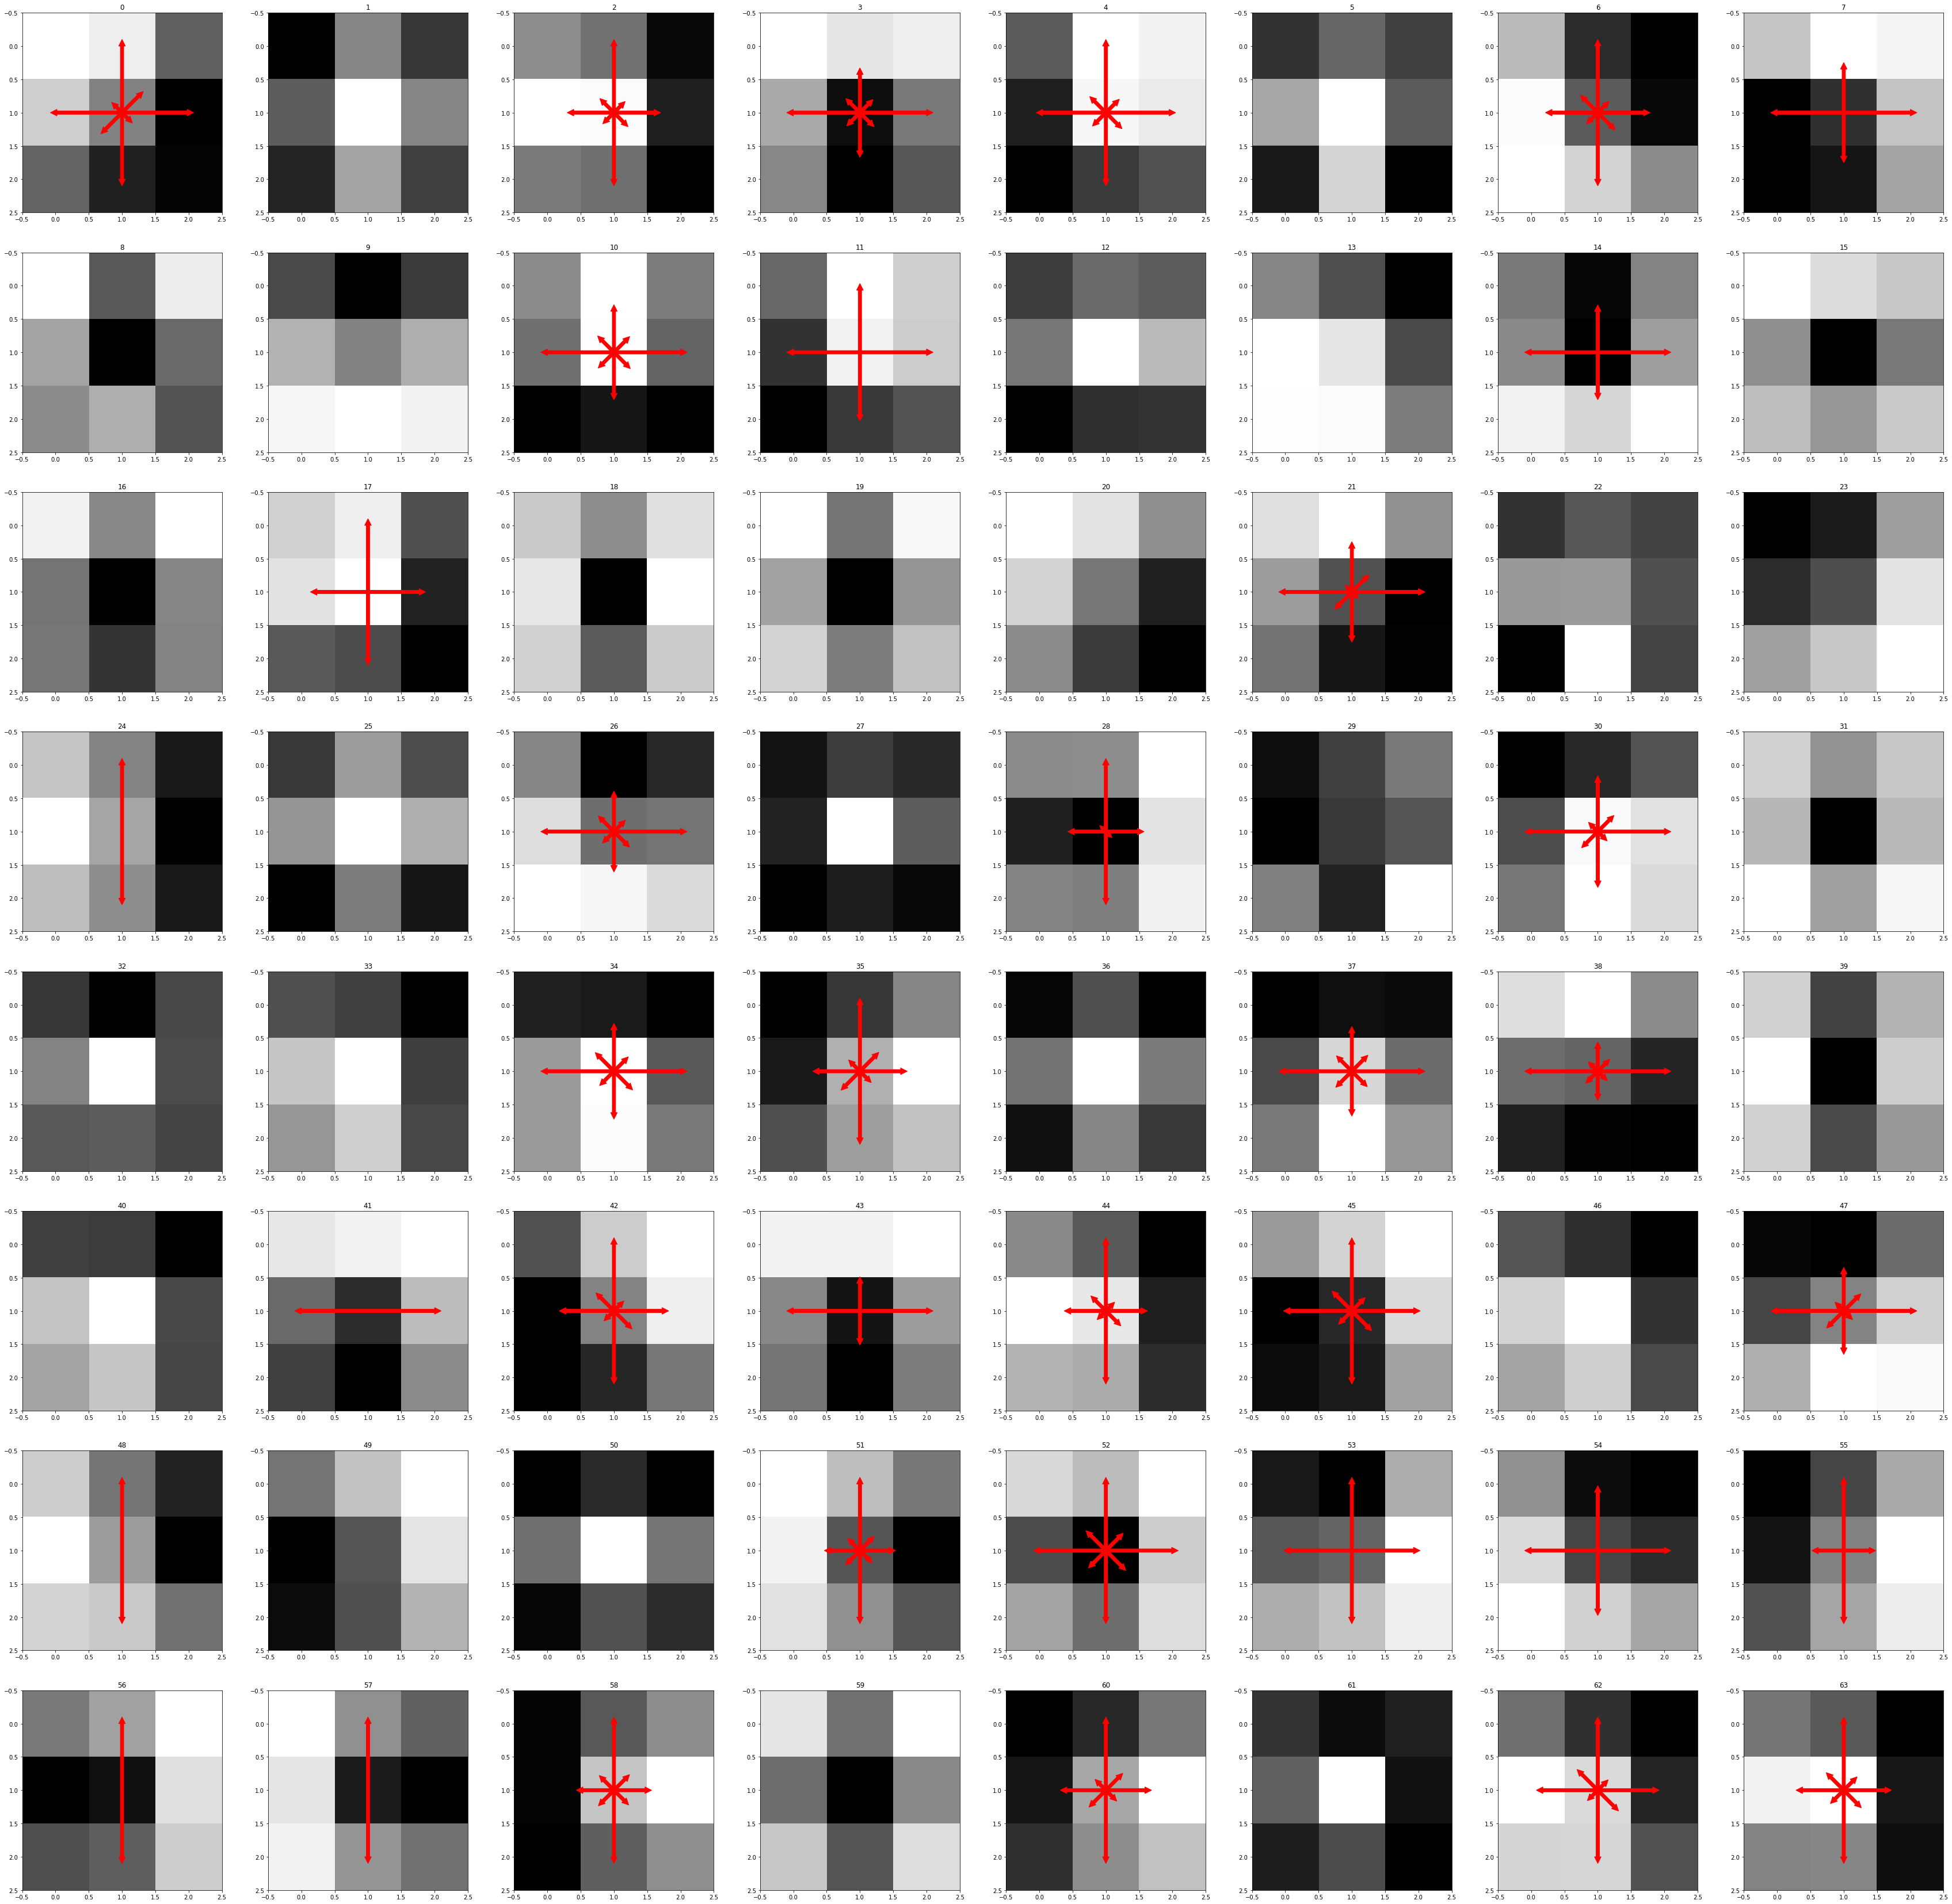

In [243]:

from skimage.feature import hog
from skimage import data, exposure

fig = plt.figure(figsize=(60, 60))

columns =8
rows = 8



filters = get_filter(1)
for i in range(filters.shape[-1]):
    filter = filters[:,:,:, i]
    #for j in range(filter.shape[-1]):
    f = filter[:,:, 0]
    a = fig.add_subplot(rows,columns, i+1)
    a.title.set_text(i)
    plotFilterDominantAngles([f])
    


plt.show();

In [225]:
f

array([[-0.11063665, -0.11243556, -0.15568645],
       [-0.01835439,  0.02441533, -0.10447415],
       [-0.04090111, -0.01628016, -0.10676192]], dtype=float32)